In [1]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

## Scipy solve_ivp

0.0025320053100585938


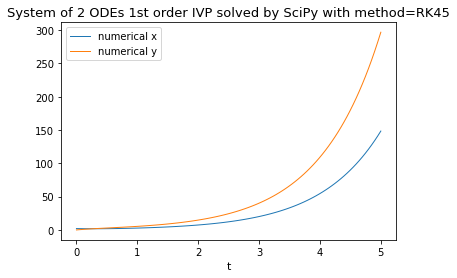

In [11]:
def ode_sys(t, XY):
	x=XY[0]
	y=XY[1]
	dx_dt= - x + y
	dy_dt= 4. * x - y
	return [dx_dt, dy_dt]

t_begin=0.
t_end=5.
t_nsamples=100
t_space = np.linspace(t_begin, t_end, t_nsamples)
x_init = 2.
y_init = 0.

method = 'RK45' #available methods: 'RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA'

t0 = time.time()
num_sol = solve_ivp(ode_sys, [t_begin, t_end], [x_init, y_init], method=method, dense_output=True)
seconds = time.time()-t0
print(seconds)

XY_num_sol = num_sol.sol(t_space)
x_num_sol = XY_num_sol[0].T
y_num_sol = XY_num_sol[1].T

plt.figure()
plt.plot(t_space, x_num_sol, linewidth=1, label='numerical x')
plt.plot(t_space, y_num_sol, linewidth=1, label='numerical y')
plt.title('System of 2 ODEs 1st order IVP solved by SciPy with method=' + method)
plt.xlabel('t')
plt.legend()
plt.show()

## TorchDiffEq

In [5]:
# Check if pytorch was correctly installed with CUDA.
import torch

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
NVIDIA GeForce RTX 2060 SUPER


0.04145383834838867


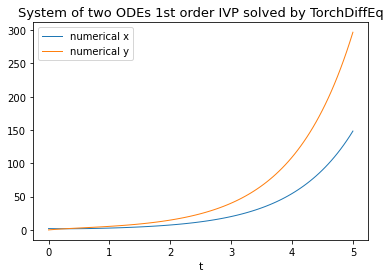

In [10]:
import torch
from torchdiffeq import odeint

def ode_sys(t, XY):
	x=XY[0]
	y=XY[1]
	dx_dt= torch.Tensor([- x + y])
	dy_dt= torch.Tensor([4. * x - y])
	return torch.cat([dx_dt, dy_dt])


t_begin=0.
t_end=5.
t_nsamples=100
t_space = np.linspace(t_begin, t_end, t_nsamples)
x_init = torch.Tensor([2.])
y_init = torch.Tensor([0.])

t0 = time.time()
num_sol = odeint(ode_sys, torch.cat([x_init, y_init]), torch.Tensor(t_space)).numpy()
seconds = time.time()-t0
print(seconds)

plt.figure()
plt.plot(t_space, num_sol[:,0], linewidth=1, label='numerical x')
plt.plot(t_space, num_sol[:,1], linewidth=1, label='numerical y')
plt.title('System of two ODEs 1st order IVP solved by TorchDiffEq')
plt.xlabel('t')
plt.legend()
plt.show()

## Numba/Cuda Example

The result was computed in 0.3848311270000977 s


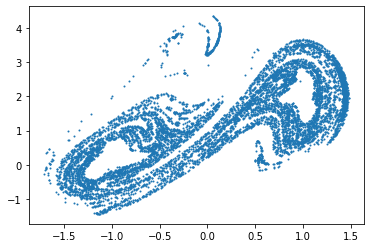

In [6]:
from numba import cuda # for parallel gpu computations
import numpy as np # for random samples and array management
import time # for timing
import math # for sinus
import matplotlib.pyplot as plt # for scatter plot


@cuda.jit
def solve_ode(x, time):
    """
    Solve 2DoF ode on gpu, given
    the initial conditions. The
    result will be stored in the
    input array.
    

    Parameters
    ----------
    x : np.array
        Contains initial conditions for the simulations.
        The elements are arranged in pairs:
        [x1_sim1, x2_sim1, x1_sim2, x2_sim2, ...]
    time : np.array
        Three-element list with time details.

    Returns
    -------
    None.

    """
    # time variables
    t = time[0]
    t_end = time[1]
    dt = time[2]
    
    # index of thread on GPU
    pos = cuda.grid(1)
    # mappping index to access every
    # second element of the array
    pos = pos * 2
    
    # condidion to avoid threads
    # accessing indices out of array
    if pos < x.size:
        # execute until the time reaches t_end
        while t < t_end:
            # compute derivatives
            dxdt0 = x[pos+1]
            dxdt1 = np.float32(10.0)*math.sin(t) - np.float32(0.1)*x[pos+1] - x[pos]**3
            
            # update state vecotr
            x[pos] += dxdt0 * dt
            x[pos+1] += dxdt1 * dt
            
            # update time
            t += dt
            
        
        
# number of independent oscillators
# to simulate
trials = 10_000

# time variables
t0 = 0
t_end = 100
dt = 0.01
t = np.array([t0, t_end, dt], dtype='float32')

# generate random initial condiotions
init_states = np.random.random_sample(2 * trials).astype('float32')

# manage nr of threads (threads)
threads_per_block = 32
blocks_per_grid = \
    (init_states.size + (threads_per_block - 1)) // threads_per_block

# start timer
start = time.perf_counter()

# start parallel simulations
solve_ode[blocks_per_grid, threads_per_block](init_states, t)

# measure time elapsed
end = time.perf_counter()
print(f'The result was computed in {end-start} s')

# reshape the array into 2D
x = init_states.reshape((trials, 2))

# plot the phase space
plt.scatter(x[:, 0], x[:, 1], s=1)

## TensorFlow Probability

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

t0 = time.time()

def ode_sys(t, XY):
	x=XY[0]
	y=XY[1]
	dx_dt= - x + y
	dy_dt= 4. * x - y
	return [dx_dt, dy_dt]

an_sol_x = lambda t : np.exp(t) + np.exp(-3. * t)
an_sol_y = lambda t : 2. * np.exp(t) - 2. * np.exp(-3. * t)

t_begin=0.
t_end=5.
t_nsamples=100
t_space = np.linspace(t_begin, t_end, t_nsamples)
t_init = tf.constant(t_begin)
x_init = tf.constant(2.)
y_init = tf.constant(0.)

x_an_sol = an_sol_x(t_space)
y_an_sol = an_sol_y(t_space)

num_sol = tfp.math.ode.BDF().solve(ode_sys, t_init, [x_init, y_init],
	solution_times=tfp.math.ode.ChosenBySolver(tf.constant(t_end)) )

plt.figure()
plt.plot(t_space, x_an_sol, '--', linewidth=2, label='analytical x')
plt.plot(t_space, y_an_sol, '--', linewidth=2, label='analytical y')
plt.plot(num_sol.times, num_sol.states[0], linewidth=1, label='numerical x')
plt.plot(num_sol.times, num_sol.states[1], linewidth=1, label='numerical y')
plt.title('System of two ODEs 1st order IVP solved by TFP with BDF')
plt.xlabel('t')
plt.legend()
plt.show()

seconds = time.time()-t0
print(seconds)